<a href="https://colab.research.google.com/github/Akage1234/Pytorch-mini-projects/blob/main/NLP/LSTM_GRU/IMDB_Sentiment_analysis_Using_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

Import from kaggle

In [ ]:
from google.colab import files
key = files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download pawankumargunjan/imdb-review

Dataset URL: https://www.kaggle.com/datasets/pawankumargunjan/imdb-review
License(s): GNU Lesser General Public License 3.0
  0% 0.00/111M [00:00<?, ?B/s]
100% 111M/111M [00:00<00:00, 1.31GB/s]


In [ ]:
!mkdir -p imdb
!unzip -q imdb-review.zip -d imdb

or download manually from https://www.kaggle.com/datasets/pawankumargunjan/imdb-review/data

In [ ]:
import os

train_texts, train_labels = [], []
test_texts, test_labels = [], []

for label_type in ["pos", "neg"]:
    train_dir = f"/content/imdb/aclImdb/train/{label_type}"
    for filename in os.listdir(train_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(train_dir, filename), "r", encoding="utf-8") as f:
                train_texts.append(f.read())
            train_labels.append(1 if label_type == "pos" else 0)

    test_dir = f"/content/imdb/aclImdb/test/{label_type}"
    for filename in os.listdir(test_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(test_dir, filename), "r", encoding="utf-8") as f:
                test_texts.append(f.read())
            test_labels.append(1 if label_type == "pos" else 0)

In [ ]:
print(len(train_texts), len(train_labels))
print(len(test_texts), len(test_labels))

25000 25000
25000 25000


# Preprocessing

In [ ]:
import nltk
from collections import Counter

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def build_vocab(texts, min_freq = 2, max_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(nltk.word_tokenize(text))

    vocab = {"<pad>":0, "<unk>":1}

    for word, freq in counter.most_common(max_size - len(vocab)):
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

word2idx = build_vocab(train_texts)
idx2word = {i: w for w, i in word2idx.items()}

In [ ]:
import pickle

# saving vocab
vocab = {"word2idx": word2idx, "idx2word": idx2word}
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [ ]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = max(lengths)

    padded = torch.zeros(len(texts), max_len, dtype=torch.long) + word2idx["<pad>"]
    for i, t in enumerate(texts):
        padded[i, :len(t)] = t

    labels = torch.tensor(labels, dtype=torch.long)
    return padded, labels

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    ids = [word2idx.get(tok, word2idx["<unk>"]) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

In [ ]:
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, transform=None):
        self.texts = texts
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, id):
        texts, labels = self.texts[id], self.labels[id]
        if self.transform:
            texts = self.transform(texts)
        return texts, labels

train_x, val_x, train_y, val_y = train_test_split(train_texts, train_labels,test_size=0.2, stratify=train_labels,random_state=42)

train_data = IMDBDataset(train_x, train_y, transform=preprocess)
val_data = IMDBDataset(val_x, val_y, transform=preprocess)
test_data = IMDBDataset(test_texts, test_labels, transform=preprocess)

In [ ]:
train_loader = DataLoader(train_data,batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn = collate_fn, num_workers=2, pin_memory=True)

# Model

In [ ]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]
        out = self.fc(h_last)
        return out

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output,  h_n = self.gru(x)
        h_last = h_n[-1]
        out = self.fc(h_last)
        return out

In [ ]:
vocab_size = len(word2idx)
embed_size = 200
hidden_size = 128
output_size = 2
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, output_size)
lstm_model = lstm_model.to(device)
gru_model = GRUModel(vocab_size, embed_size, hidden_size, output_size)
gru_model = gru_model.to(device)

# Training

In [ ]:
import torch.optim as optim
from tqdm import tqdm

In [ ]:
n_epochs = 5
learning_rate = 1e-3
optimizerLSTM = optim.Adam(lstm_model.parameters(), lr=learning_rate)
optimizerGRU = optim.Adam(gru_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs=5, learning_rate=1e-3):
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(n_epochs):
        with tqdm(len(train_loader)+len(val_loader), desc=f"Epoch:{epoch+1}/{n_epochs}") as pbar:
            model.train()
            total_loss, correct, total = 0.0, 0, 0
            for batch, labels in train_loader:
                batch = batch.to(device)
                labels = labels.to(device)

                pred = model(batch)
                loss = criterion(pred, labels)
                total_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                preds = pred.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                pbar.update(1)

            avg_train_loss = total_loss/len(train_loader)
            train_acc = 100 * correct / total
            train_losses.append(avg_train_loss)
            train_accs.append(train_acc)

            model.eval()
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for batch, labels in val_loader:
                    batch, labels = batch.to(device), labels.to(device)

                    pred = model(batch)
                    loss = criterion(pred, labels)
                    val_loss += loss.item()

                    preds = pred.argmax(dim=1)
                    correct += (preds==labels).sum().item()
                    total += labels.size(0)

                    pbar.update(1)

            avg_val_loss = val_loss/len(val_loader)
            val_acc = 100 * correct / total
            val_losses.append(avg_val_loss)
            val_accs.append(val_acc)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(),f"best_{model.__class__.__name__}.pth")

        print(f"Epoch: {epoch+1}/{n_epochs} | train_loss:{avg_train_loss:.4f} | train_accuracy:{train_acc:.2f} | val_loss: {avg_val_loss:.4f} | val_accuracy:{val_acc:.2f}")
    return train_losses, val_losses, train_accs, val_accs

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(lstm_model, train_loader, val_loader, optimizerLSTM, criterion, 15, learning_rate)

Epoch:1/15: 392it [00:32, 11.98it/s]


Epoch: 1/15 | train_loss:0.6881 | train_accuracy:50.04 | val_loss: 0.6939 | val_accuracy:50.10


Epoch:2/15: 392it [00:33, 11.61it/s]


Epoch: 2/15 | train_loss:0.6876 | train_accuracy:50.02 | val_loss: 0.6962 | val_accuracy:50.16


Epoch:3/15: 392it [00:32, 12.00it/s]


Epoch: 3/15 | train_loss:0.6867 | train_accuracy:50.11 | val_loss: 0.6952 | val_accuracy:50.12


Epoch:4/15: 392it [00:33, 11.76it/s]


Epoch: 4/15 | train_loss:0.6864 | train_accuracy:50.91 | val_loss: 0.6954 | val_accuracy:50.14


Epoch:5/15: 392it [00:34, 11.22it/s]


Epoch: 5/15 | train_loss:0.6858 | train_accuracy:51.27 | val_loss: 0.6944 | val_accuracy:50.26


Epoch:6/15: 328it [00:27, 11.72it/s]


KeyboardInterrupt: 

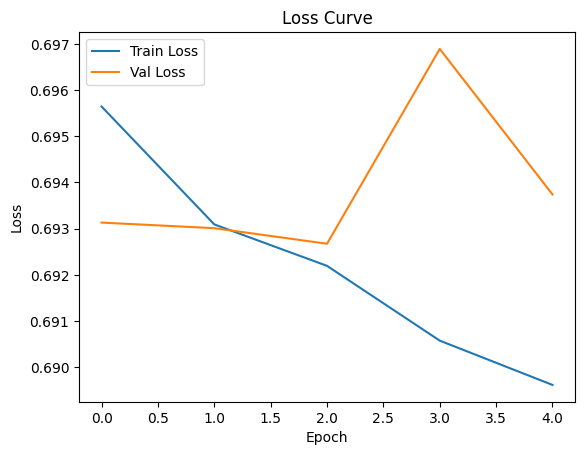

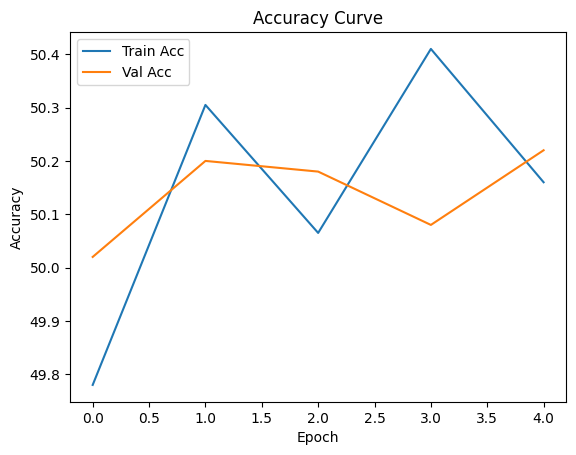

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.show()

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(gru_model, train_loader, val_loader, optimizerGRU, criterion, 5, learning_rate)

Epoch:1/5: 392it [00:32, 11.97it/s]


Epoch: 1/5 | train_loss:0.6981 | train_accuracy:50.58 | val_loss: 0.6934 | val_accuracy:50.36


Epoch:2/5: 392it [00:32, 11.95it/s]


Epoch: 2/5 | train_loss:0.6725 | train_accuracy:57.13 | val_loss: 0.6317 | val_accuracy:66.46


Epoch:3/5: 392it [00:31, 12.46it/s]


Epoch: 3/5 | train_loss:0.5572 | train_accuracy:72.56 | val_loss: 0.6888 | val_accuracy:61.30


Epoch:4/5: 392it [00:32, 12.03it/s]


Epoch: 4/5 | train_loss:0.5561 | train_accuracy:71.56 | val_loss: 0.4978 | val_accuracy:75.78


Epoch:5/5: 392it [00:31, 12.39it/s]

Epoch: 5/5 | train_loss:0.4044 | train_accuracy:82.14 | val_loss: 0.4282 | val_accuracy:81.20


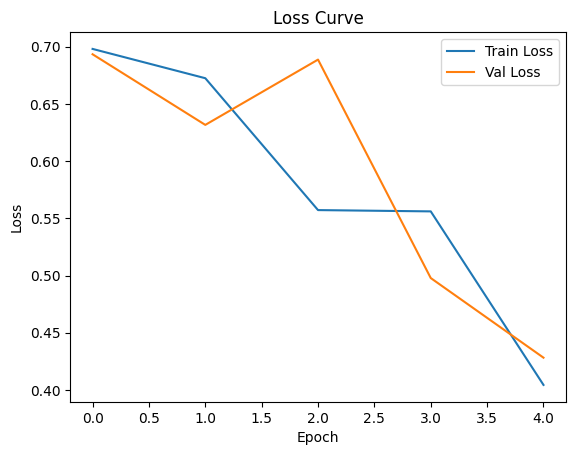

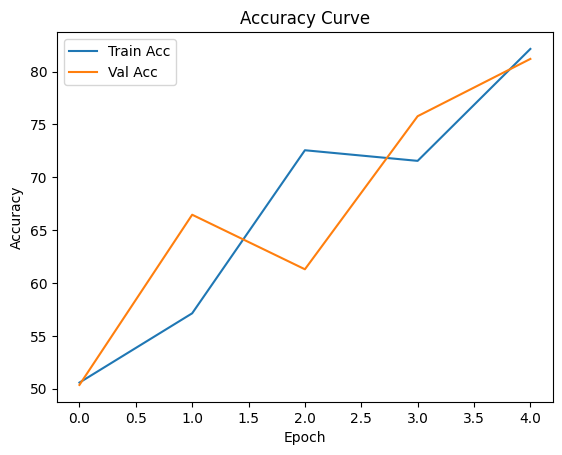

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.show()

# Validation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
model.eval()

LSTMModel(
  (embedding): Embedding(20000, 200)
  (lstm): LSTM(200, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
test_loss, correct, total = 0, 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels in test_loader:
        batch, labels = batch.to(device), labels.to(device)
        pred = model(batch)

        loss = criterion(pred, labels)
        test_loss += loss.item()

        preds = pred.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.2f}%")

Validation Loss: 0.6933 | Validation Accuracy: 50.08%


In [ ]:
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.50      0.99      0.67     12500
    Positive       0.55      0.01      0.02     12500

    accuracy                           0.50     25000
   macro avg       0.53      0.50      0.34     25000
weighted avg       0.53      0.50      0.34     25000



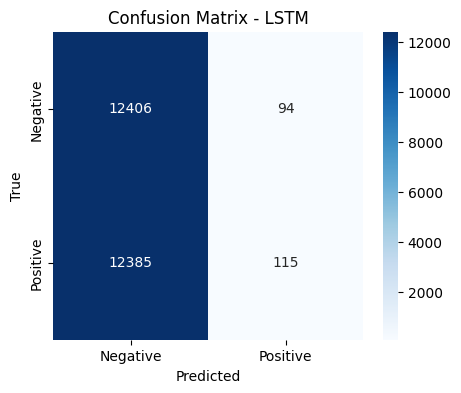

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LSTM")
plt.show()

In [ ]:
model = GRUModel(vocab_size, embed_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
model.eval()

GRUModel(
  (embedding): Embedding(20000, 200)
  (gru): GRU(200, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
test_loss, correct, total = 0, 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels in test_loader:
        batch, labels = batch.to(device), labels.to(device)
        pred = model(batch)

        loss = criterion(pred, labels)
        test_loss += loss.item()

        preds = pred.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.2f}%")

Validation Loss: 0.4395 | Validation Accuracy: 79.78%


In [ ]:
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.75      0.89      0.82     12500
    Positive       0.87      0.70      0.78     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



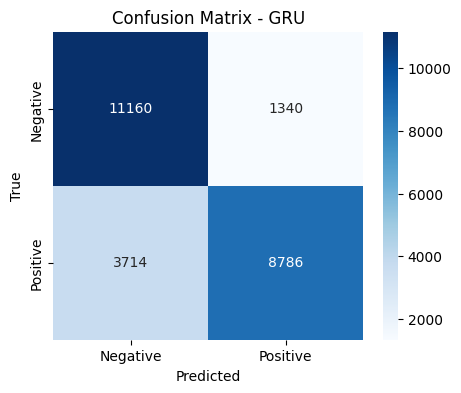

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU")
plt.show()